<a href="https://colab.research.google.com/github/veselm73/sdueba-subgroup-discovery/blob/main/SDUEBA_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r https://raw.githubusercontent.com/veselm73/BP/main/requirements_SDUEBA010.txt --quiet
!pip install umap-learn --quiet
!git clone https://github.com/uef-machine-learning/tspgclu.git
%cd tspgclu
!pip install -r requirements.txt --quiet
!pip install . --quiet
!python python/ex_cluster.pyimport tspg
import tspg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packag

In [ ]:
# Dependencies
import numpy as np
import scipy
import os
import re
import string
import pandas as pd
from collections import Counter
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import gensim
from gensim.models import Word2Vec
import tspg

In [ ]:
#SDUEBA Parameters:
"""
vector_space_dimention  ... dimension of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
"""

frac_of_dataset = 1
n_features = 30
descriptive_format = True

vector_space_dimension = 100
n_clusters = 45
clustering_method = "tspg"      #"agglomerative"/"spherical_kmeans"/"tspg"
frac_of_dataset = 1

max_depth = 2
test_size = 0.2
mixed_threshold = 0.9
tree_accuracy_threshold = 0.95

target_column = 'readmit_binary'
target_value = 'Yes'

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 200

In [ ]:
import time
start_time = time.time()

#Best feature selection
def create_shorter_sample(df, frac=None):
    df_sampled = df.sample(frac=frac, random_state=73)
    df_sampled = df_sampled.reset_index(drop=True)
    return df_sampled

def normalize_weights(weights):
    weights_array = np.array(weights)
    min_val = np.min(weights_array)
    max_val = np.max(weights_array)

    if max_val == min_val:
      return np.zeros_like(weights_array)

    normalized_weights = (weights_array - min_val) / (max_val - min_val)
    return normalized_weights

file_path = "https://kmlinux.fjfi.cvut.cz/~veselm73/diabetes_preprocessed.csv"

df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)
df = df.drop(columns=['readmitted', 'readmit_30_days'])
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

X = df_imputed.drop(columns=["readmit_binary"])
y = df_imputed["readmit_binary"]

model = RandomForestClassifier(n_estimators=100, random_state=73)
model.fit(X, y)

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': normalize_weights(model.feature_importances_)})
feature_weights = pd.concat([feature_weights, pd.DataFrame({'Feature': [target_column], 'Weight': [1]})], ignore_index=True)
# feature_weights.head(30)
print((df['primary_diag_desc'].head(10)).tolist())

/tmp/ipython-input-2268922705.py:23: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)


['Depressive disorder, not elsewhere classified', 'Malignant neoplasm of trachea', 'Postinflammatory pulmonary fibrosis', 'Coronary atherosclerosis of unspecified type of vessel, native or graft', 'Diabetes with hyperosmolarity, type II or unspecified type, uncontrolled', 'Simple type schizophrenia, unspecified', 'Diabetes with other specified manifestations, type II or unspecified type, not stated as uncontrolled', 'Orthostatic hypotension', 'Calculus of kidney', 'Congestive heart failure, unspecified']


In [ ]:
#Data augemntation
def create_quantile_categorical_feature(df, feature_name):

    if feature_name not in df.columns:
        print(f"Error: Feature '{feature_name}' not found in DataFrame.")
        return df

    num_quantiles = 5
    quantiles = np.linspace(0, 1, num_quantiles + 1)
    bins = df[feature_name].quantile(quantiles).tolist()
    bins[-1] = float('inf')

    bins = sorted(list(set(bins)))

    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    if len(bins) - 1 < 5:
        labels = labels[:len(bins) - 1]

    df[f'{feature_name}_category'] = pd.cut(df[feature_name], bins=bins, labels=labels, include_lowest=True, duplicates='drop')
    df = df.drop(columns=[feature_name])

    return df

top_features = feature_weights.sort_values(by='Weight', ascending=False).head(n_features)['Feature']
features_raw = df[top_features]
features_raw = features_raw.drop(columns=[target_column])

target_df = df[['readmit_binary']].copy()
target_df['readmit_binary'] = target_df['readmit_binary'].astype(str).replace({'True': 'Yes', 'False': 'No'})



for column in ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_diagnoses', 'num_procedures', 'number_inpatient', 'number_outpatient']:
    features_raw = create_quantile_categorical_feature(features_raw, column)


features_raw.head()
training_df = pd.merge(target_df, features_raw, left_index=True, right_index=True)

In [ ]:
# Sentence creation
training_df = pd.merge(target_df, features_raw, left_index=True, right_index=True).astype(str)
class SentenceFormatter:
    def __init__(self, dataframe, descriptive_format=True):

        self.df = dataframe.copy()
        self.descriptive_format = descriptive_format

    def _prettify_column_names(self):

        return [' '.join(col.split('_')) for col in self.df.columns]

    def generate_sentences(self):

        sentences = []
        if self.descriptive_format:
            pretty_columns = self._prettify_column_names()
            for _, row in self.df.iterrows():
                sentence = [f"{col_name} is {val}" for col_name, val in zip(pretty_columns, row)]
                sentences.append(sentence)
        else:
            for _, row in self.df.iterrows():
                sentence = [str(val) for val in row]
                sentences.append(sentence)

        return sentences

formatter = SentenceFormatter(training_df, descriptive_format=descriptive_format)
sentences = formatter.generate_sentences()
print(sentences[0])

['readmit binary is Yes', 'primary diag desc is Depressive disorder, not elsewhere classified', 'diag 2 desc is Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled', 'diag 3 desc is Extrinsic asthma, unspecified', 'age is [80-90)', 'medical specialty is nan', 'payer code is nan', 'discharge disposition is Discharged to home', 'discharge disposition id is 1', 'insulin is No', 'race is Caucasian', 'had inpatient days is True', 'A1Cresult is None', 'gender is Female', 'admission type is Urgent', 'admission type id is 2', 'metformin is No', 'admission source is  Emergency Room', 'admission source id is 7', 'glipizide is No', 'change is No', 'glyburide is Steady', 'diabetesMed is Yes', 'num lab procedures category is High', 'num medications category is Medium', 'time in hospital category is Very High', 'number diagnoses category is Medium', 'num procedures category is Very Low', 'number inpatient category is Very Low', 'number outpatien

In [ ]:
#Word2Vec training and clustering
class Word2VecModel:
    def __init__(self, sentences, vector_size, window=5, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        return np.mean(word_embeddings, axis=0) if word_embeddings else np.zeros(self.model.vector_size)

class SentenceEmbedder:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def generate_embeddings(self, sentences, normalize=False):
        embeddings = np.array([self.word2vec_model.get_embedding(sentence) for sentence in sentences])
        return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) if normalize else embeddings

class SphericalKMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for _ in range(self.max_iter):
            similarities = X @ self.cluster_centers_.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else self.cluster_centers_[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        X = normalize(X, norm='l2', axis=1)
        similarities = X @ self.cluster_centers_.T
        return np.argmax(similarities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

class ClusteringModel:
    def __init__(self, n_clusters, method="spherical_kmeans", random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.model = self._initialize_model()

    def _initialize_model(self):
        if self.method == "agglomerative":
            return AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average')
        elif self.method == "spherical_kmeans":
            return SphericalKMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        elif self.method == "tspg":
            return self
        else:
            raise ValueError("Unsupported clustering method")

    def fit_predict(self, embeddings):
        if self.method == "tspg":
            return self._tspg_clustering(embeddings)
        return self.model.fit_predict(embeddings)

    def _tspg_clustering(self, embeddings):
        labels, _ = tspg.tspg(embeddings.tolist(), self.n_clusters, distance="cos", num_tsp=30, dtype="vec")
        labels = [x-1 for x in labels]
        return np.array(labels)

word2vec_model = Word2VecModel(sentences, vector_size=vector_space_dimension)
sentence_embedder = SentenceEmbedder(word2vec_model)
embeddings = sentence_embedder.generate_embeddings(sentences, normalize=True)
clustering_model = ClusteringModel(n_clusters, method=clustering_method)
labels = clustering_model.fit_predict(embeddings)

In [ ]:
#Decision tree training
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)
        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y
            )

    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [ ]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, mixed_threshold, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold):
        self.data_frame = data_frame
        self.target_df = target_df
        self.mixed_threshold = mixed_threshold
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self.target_column = target_df.columns[0]
        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            class_probabilities = value[0] / value.sum()
            predicted_class = class_probabilities.argmax()
            rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _extract_rules_for_clusters(self):
        cluster_class_counts = {}
        for i, cluster in enumerate(self.cluster_labels):
            class_label = self.target_df[self.target_column][i]
            cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
            cluster_class_counts[cluster][class_label] += 1

        N = len(self.target_df)
        class_counts = {class_: sum(self.target_df[self.target_column] == class_) for class_ in set(self.target_df[self.target_column])}
        n_dict = {}

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = class_percentages
            self.tp_dict[cluster] = max(class_counts.values())
            self.fp_dict[cluster] = total_count - self.tp_dict[cluster]
            n_dict[cluster] = total_count

            self.TP_dict[cluster] = self.tp_dict[cluster]
            self.FP_dict[cluster] = N - self.tp_dict[cluster]
            self.WRAcc_dict[cluster] = ((self.tp_dict[cluster] + self.fp_dict[cluster]) / N) * (self.tp_dict[cluster] / n_dict[cluster] - self.TP_dict[cluster] / N)

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy lower than the given threshold"]
                else:
                    rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                    self.rules_dict[cluster] = rules_list if rules_list else self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)

    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items())
            rules = self.rules_dict.get(cluster, None)

            if rules is None:
                rules = ["No rules extracted"]

            print(f"Cluster {cluster}: support = {self.cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {self.WRAcc_dict[cluster]}")

            for rule in rules:
                print(f"  - {rule}")

        print("\nUnextractable Clusters:", self.unextractable_clusters)


clusters = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    mixed_threshold=mixed_threshold,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold
)
clusters.print_summary()


Formatted Cluster Summary:
Cluster 0: support = 751, 'Yes': 0.4, 'No': 0.6, WRAcc = 0.0044185386794403925
  - admission_type_id_5 <= 0.50 AND admission_source_nan <= 0.50
  - admission_type_id_5 <= 0.50 AND admission_source_nan > 0.50
  - admission_type_id_5 > 0.50 AND change_Ch <= 0.50
  - admission_type_id_5 > 0.50 AND change_Ch > 0.50
Cluster 1: support = 917, 'No': 0.5, 'Yes': 0.5, WRAcc = 0.004498918882059948
  - medical_specialty_Emergency/Trauma <= 0.50 AND admission_type_id_2 <= 0.50
  - medical_specialty_Emergency/Trauma <= 0.50 AND admission_type_id_2 > 0.50
  - medical_specialty_Emergency/Trauma > 0.50 AND discharge_disposition_id_1 <= 0.50
  - medical_specialty_Emergency/Trauma > 0.50 AND discharge_disposition_id_1 > 0.50
Cluster 2: support = 451, 'No': 0.49, 'Yes': 0.51, WRAcc = 0.002240287842295147
  - discharge_disposition_id_7 <= 0.50 AND discharge_disposition_Discharged to home <= 0.50
  - discharge_disposition_id_7 <= 0.50 AND discharge_disposition_Discharged to home

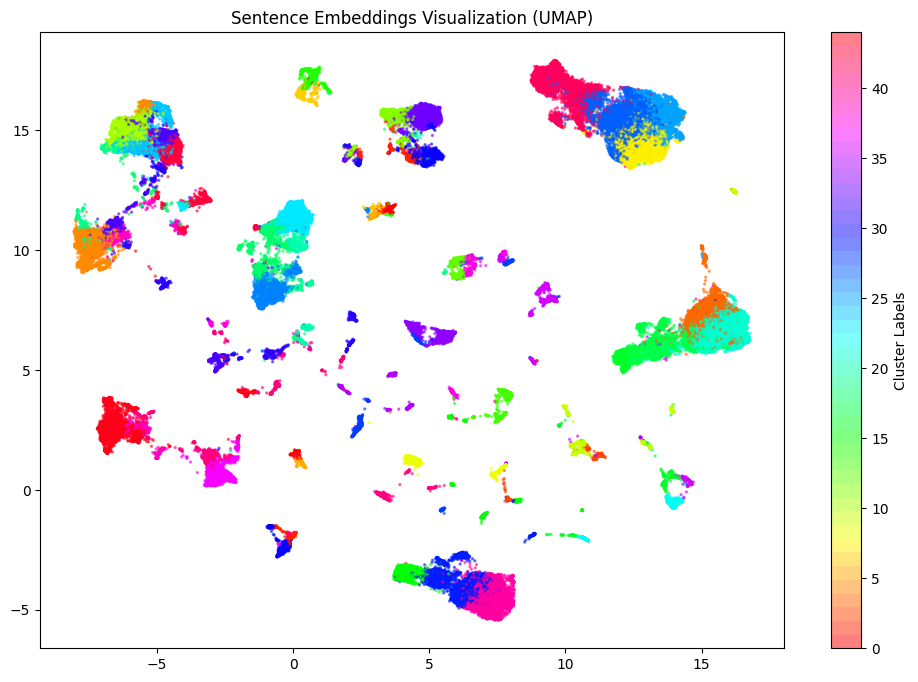

In [ ]:
# Clusters visualization
import umap
def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None):
    plt.figure(figsize=(12, 8))

    reducer = umap.UMAP(n_components=2, random_state=73, n_neighbors=15, min_dist=0.1)
    embeddings_2d = reducer.fit_transform(np.array(embeddings))

    cluster_labels = np.array(cluster_labels)

    cmap = plt.get_cmap('hsv', len(set(cluster_labels)))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cmap, alpha=0.5, s=2)

    plt.colorbar(scatter, label='Cluster Labels')
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.show()

plot_sentence_embeddings(embeddings, cluster_labels=labels, clustering_method='UMAP')

In [ ]:
class SubgroupCreator:
    def __init__(self, X_df, targets_df, target_value):
        self.X_df = X_df
        self.targets_df = targets_df
        self.target_value = target_value
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.targets_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.targets_df == self.target_value).sum().item()
        FP = (self.targets_df != self.target_value).sum().item()

        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        return tp, fp, TP, FP, WRAcc, covered_indices, description
    def evaluate_all_clusters(self, subgroups):
        with open("results_SDUEBA.txt", "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )

                        f.write(
                            f"Description: [{description_str}], Target: class = '{self.target_value}' ; "
                            f"PIQ = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.targets_df)}\n")

dataset = training_df
evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value='Yes')
evaluator.evaluate_all_clusters(clusters)

In [ ]:
#coverage and overlap ratio
def compute_coverage(filename, quality_measure, k, dataset_size, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    return coverage, overlap_ratio

print("SDUEBA model:")
coverage_SDUEBA, overlap_SDUEBA = compute_coverage('results_SDUEBA.txt', 'PIQ', 25, len(target_df), True)
print(f"Coverage: {coverage_SDUEBA}, Overlap Ratio: {overlap_SDUEBA}")

SDUEBA model:
Top-k subgroups:
Description: [discharge_disposition_id = '11', diabetesMed ≠ 'No'], Target: class = 'Yes' ; PIQ = 0.23044042 ; WRAcc = -0.00491378 ; tp = 0 ; fp = 1085 ; TP = 46902 ; FP = 54864
Description: [discharge_disposition_id = '11', diabetesMed = 'No'], Target: class = 'Yes' ; PIQ = 0.23044042 ; WRAcc = -0.00252256 ; tp = 0 ; fp = 557 ; TP = 46902 ; FP = 54864
Description: [medical_specialty = 'ObstetricsandGynecology', insulin = 'No'], Target: class = 'Yes' ; PIQ = 0.14928100 ; WRAcc = -0.00101216 ; tp = 56 ; fp = 289 ; TP = 46902 ; FP = 54864
Description: [discharge_disposition_id ≠ '3', admission_source_id = '6'], Target: class = 'Yes' ; PIQ = 0.10201937 ; WRAcc = -0.00380946 ; tp = 488 ; fp = 1412 ; TP = 46902 ; FP = 54864
Description: [medical_specialty = 'ObstetricsandGynecology', insulin ≠ 'No'], Target: class = 'Yes' ; PIQ = 0.09853858 ; WRAcc = -0.00063132 ; tp = 86 ; fp = 240 ; TP = 46902 ; FP = 54864
Description: [admission_source = ' Transfer from ano

In [ ]:
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Total execution time: 825.99 seconds
